In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import pydicom
import seaborn as sns
from glob import glob
from tqdm import tqdm
from matplotlib import patches as patches

import numpy as np 
import pandas as pd 
import pydicom,os,cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
import pydicom as dicom

In [4]:
from glob import glob
train = sorted(glob('C:/Users/HP/siim/dicom-images-train/*/*/*.dcm'))
test = sorted(glob('C:/Users/HP/siim/dicom-images-test/*/*/*.dcm'))

print(f'Number of train dicom files in folder:{len(train)}')
print(f'Number of test dicom files in folder:{len(test)}')

dataset = pd.read_csv("C:/Users/HP/siim/train-rle.csv", delimiter=",")
print(dataset.shape)

print(f'Total no of unique images in csv file: {dataset["ImageId"].nunique()}')
print(f'Images with duplicate Encoded pixels, ie multiple annotations:{dataset[dataset.duplicated(subset=["ImageId"])].shape[0]}')

dataset.head()






Number of train dicom files in folder:12089
Number of test dicom files in folder:3205
(12954, 2)
Total no of unique images in csv file: 12047
Images with duplicate Encoded pixels, ie multiple annotations:907


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [6]:
missing_images=0
train_df=[]
for i in tqdm(train):
  sample=pydicom.dcmread(i) #reading each image
  train={}
  train["UID"]=sample.SOPInstanceUID 
  try: #try and except to avoid throwing an error in case any file is missing
    encoded_pixels = dataset[dataset["ImageId"] == train["UID"]].values[0][1] #We are checking wheather each image(from the train) present has been mapped to the csv file given . 
    train["EncodedPixels"]=encoded_pixels
  except:
    missing_images=missing_images+1 #if the image details are not present in the csv that means that the file is missing
  train["Age"] = sample.PatientAge 
  train["Sex"] = sample.PatientSex
  train["ViewPosition"] = sample.ViewPosition
  train["path"] = "pneumothorax/dicom-images-train/" + sample.StudyInstanceUID + "/" + sample.SeriesInstanceUID + "/" + sample.SOPInstanceUID + ".dcm" #saving the path in csv for further reference
  train_df.append(train)

patients_train = pd.DataFrame(train_df,columns=["UID", "EncodedPixels", "Age", "Sex","ViewPosition","path"])

100%|████████████████████████████████████████████████████████████████████████████| 12089/12089 [04:44<00:00, 42.48it/s]


In [7]:
patients_train.head()

,UID,EncodedPixels,Age,Sex,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,PA,pneumothorax/dicom-images-train/1.2.276.0.7230...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...


In [8]:
print("There are {} images missing based on the given CSV file".format(missing_images))
patients_train['Age']=patients_train['Age'].astype(float)
patients_train.head()

There are 42 images missing based on the given CSV file


,UID,EncodedPixels,Age,Sex,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38.0,M,PA,pneumothorax/dicom-images-train/1.2.276.0.7230...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65.0,M,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...


****************************************************************************************************
The number of patients who are not diagnosed with Pneumothorax are 9378
The number of patients who are diagnosed with Pneumothorax are 2711
****************************************************************************************************


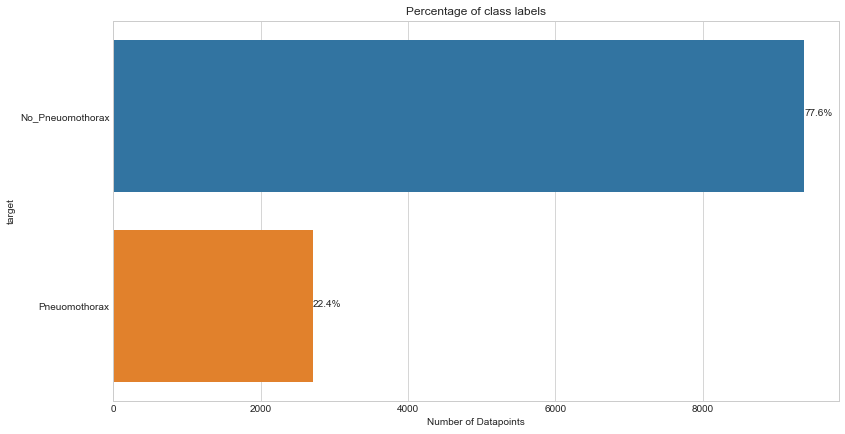

In [9]:
pneumothorax=0
No_pneumothorax=0
target=[]
for i in patients_train['EncodedPixels']:
  if str(i).strip()=="-1":
    No_pneumothorax=No_pneumothorax+1
    target.append("No_Pneuomothorax")
  else:
    pneumothorax=pneumothorax+1
    target.append("Pneuomothorax")
Data=patients_train.copy()
Data['target']=target

print('*'*100)
print("The number of patients who are not diagnosed with Pneumothorax are",No_pneumothorax)
print("The number of patients who are diagnosed with Pneumothorax are",pneumothorax)
print('*'*100)
plt.figure(figsize=(13,7))
ax=sns.countplot(y='target',data=Data)
plt.title('Percentage of class labels')
plt.xlabel('Number of Datapoints')

total = len(Data['target'])
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))

plt.show()

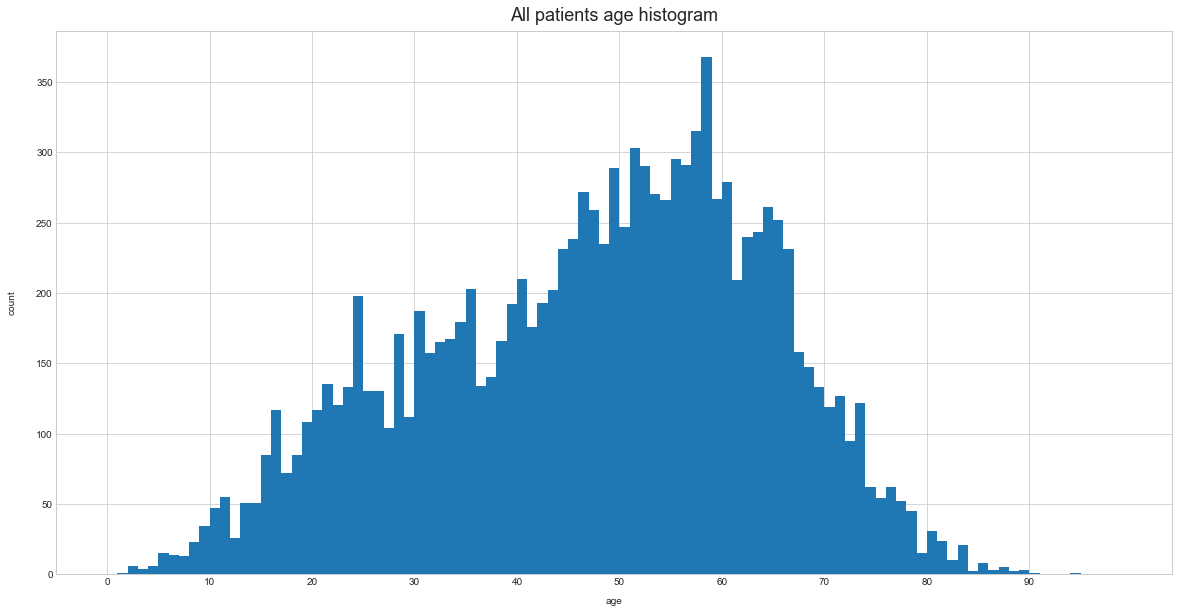

In [10]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10))
plt.hist(sorted(Data['Age']), bins=[i for i in range(100)])
plt.title("All patients age histogram", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*10 for i in range(10)])
plt.ylabel("count", labelpad=20)
plt.show()

<AxesSubplot:xlabel='Age', ylabel='target'>

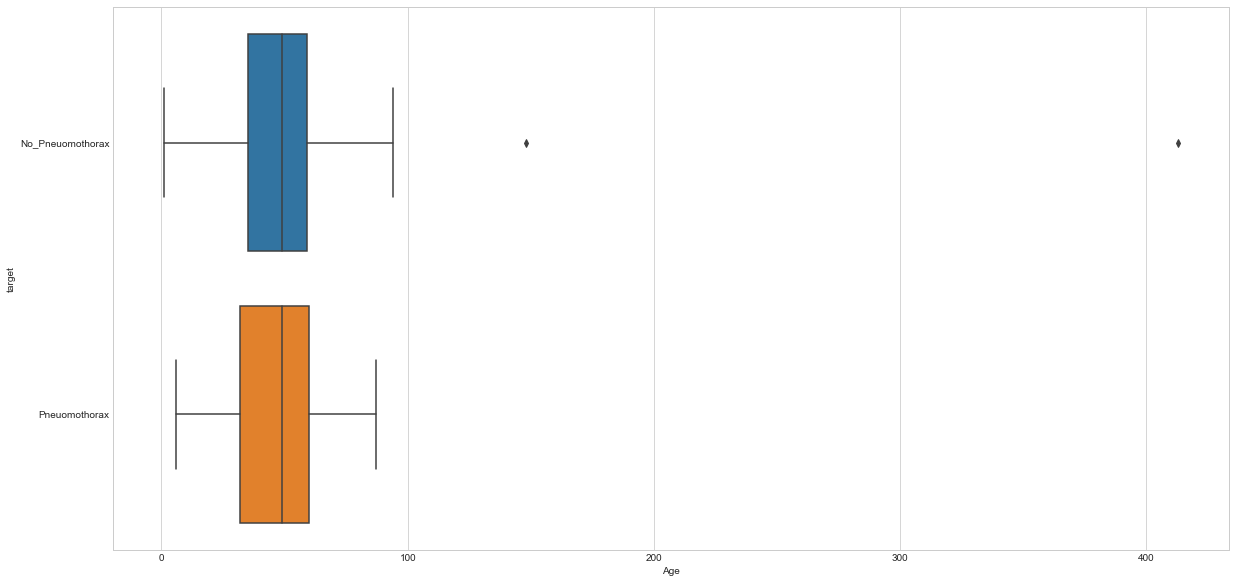

In [11]:
plt.figure(figsize=(20,10))
sns.boxplot(x=Data['Age'],y=Data['target'])

In [12]:
print("The valued of the age which is an outlier is",sorted(Data['Age'])[-1])
print("The valued of the age which is an outlier is",sorted(Data['Age'])[-2])

The valued of the age which is an outlier is 413.0
The valued of the age which is an outlier is 148.0


In [13]:
print(np.median(Data['Age']))
print(np.mean(Data['Age']))

49.0
46.98717842666887


The number of Male diagnosed with Pneumothorax are  6650
The number of Female diagnosed with Pneumothorax are  5439
****************************************************************************************************


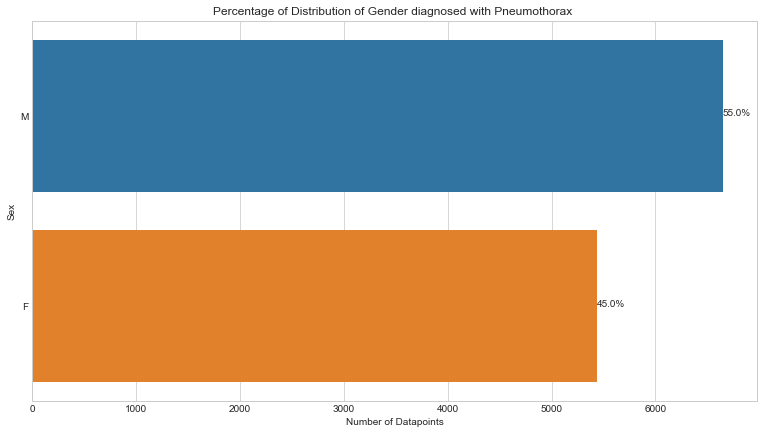

In [14]:
m=0
f=0
with_pneumonia=Data[Data["EncodedPixels"] != ' -1']['Sex'] #Patients Gender where the patient has been diagnosed with Pneumothorax 
with_pneumonia=pd.DataFrame(with_pneumonia)
with_pneumonia.columns=["Sex"]
for i in with_pneumonia["Sex"]:
  if i=='M':
    m=m+1
  else:
    f=f+1

print("The number of Male diagnosed with Pneumothorax are ",m)
print("The number of Female diagnosed with Pneumothorax are ",f)
print("*"*100)
plt.figure(figsize=(13,7))
ax=sns.countplot(y='Sex',data=with_pneumonia)
plt.title('Percentage of Distribution of Gender diagnosed with Pneumothorax ')
plt.xlabel('Number of Datapoints')

total = len(with_pneumonia)
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))

plt.show()

In [245]:
Data["Sex"].value_counts()

M    6650
F    5439
Name: Sex, dtype: int64

In [246]:
print((1067/4809)*100)
print((1349/5903)*100)

22.18756498232481
22.85278671861765


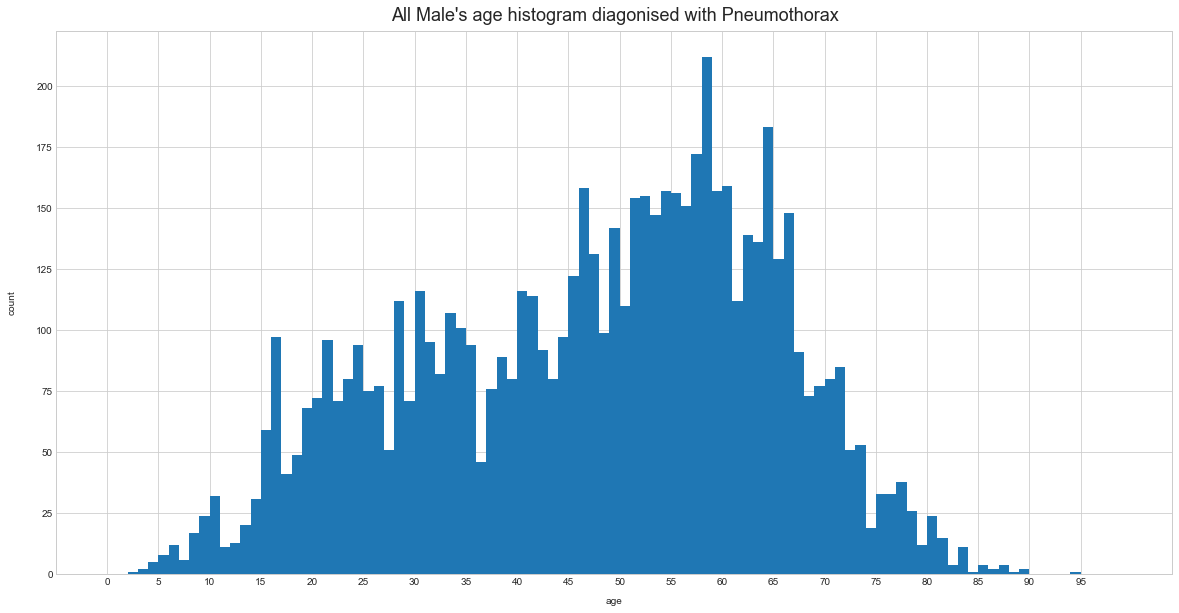

In [15]:
pneumothorax = Data.loc[Data['EncodedPixels'] != ' -1' ] #Data of patients affected with Pneumothorax
male_pneumothorax=pneumothorax.loc[pneumothorax['Sex'] =='M']  #Patients who have been affected Pneumothorax and are male
female_pneumothorax=pneumothorax.loc[pneumothorax['Sex'] =='F'] #Patients who have been affected Pneumothorax and are female
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10))
plt.hist(sorted(male_pneumothorax['Age']), bins=[i for i in range(100)])

plt.title("All Male's age histogram diagonised with Pneumothorax", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*5 for i in range(20)])
plt.ylabel("count", labelpad=20)
plt.show()

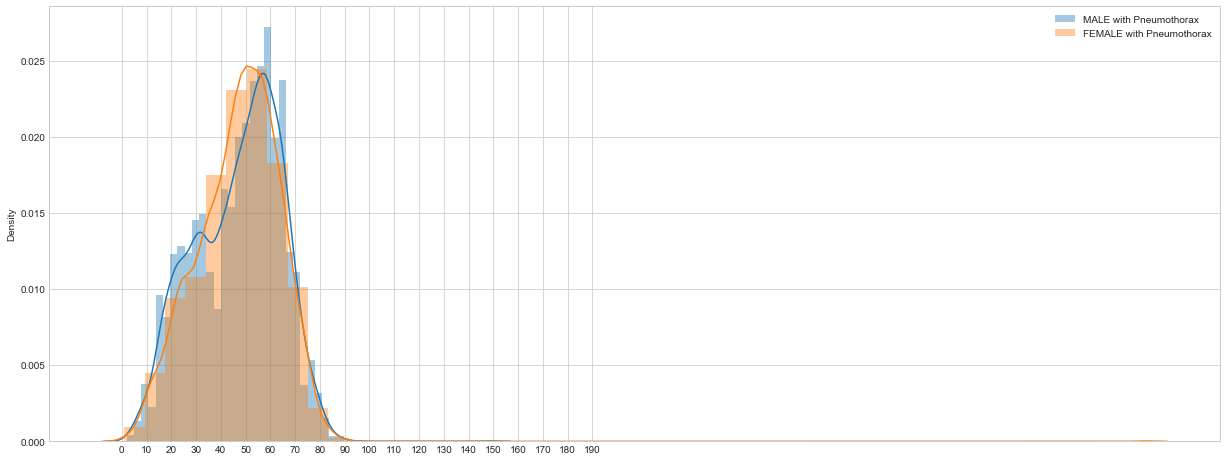

In [38]:
plt.figure(figsize=(21,8))
sns.distplot(sorted(male_pneumothorax['Age']),kde=True,label="MALE with Pneumothorax")
sns.distplot(sorted(female_pneumothorax['Age']),kde=True,label="FEMALE with Pneumothorax")
plt.xticks([i*10 for i in range(20)])
plt.legend()
plt.show()

# RLE

In [255]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    img = img.detach().cpu().numpy()


    for y in range(height):
        for x in range(width):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel += 1
        if lastColor == 255:
            rle.append(str(runStart))
            rle.append(str(runLength))

    return " ".join(rle)


def rle2mask(rle, width, height):
    mask = np.zeros(width * height)
    if rle != '-1':
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position + lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height)

def zero_out_the_small_regions(mask_batch, area_threshold=0.002):
    above_threshold = mask_batch.sum(dim=(1, 2, 3), keepdim=True) > area_threshold
    mask_batch *= above_threshold.type(dtype=mask_batch.type())
    return mask_batch

In [274]:
with_pneumothorax = patients_train[patients_train["EncodedPixels"] != ' -1'] #patients with Pnuemothorax
with_pneumothorax.head()


,UID,EncodedPixels,Age,Sex,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38.0,M,PA,pneumothorax/dicom-images-train/1.2.276.0.7230...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68.0,F,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65.0,M,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...


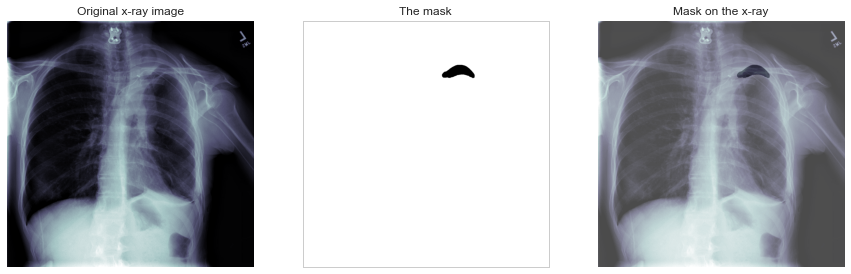

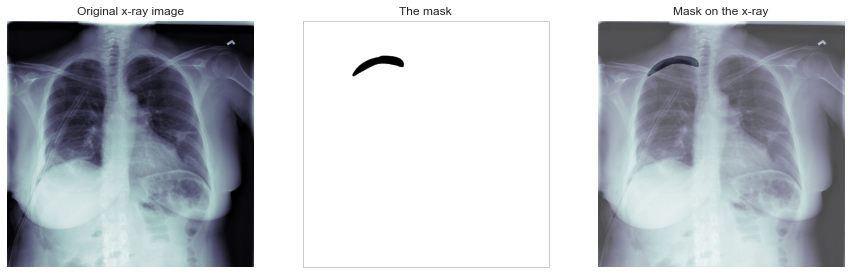

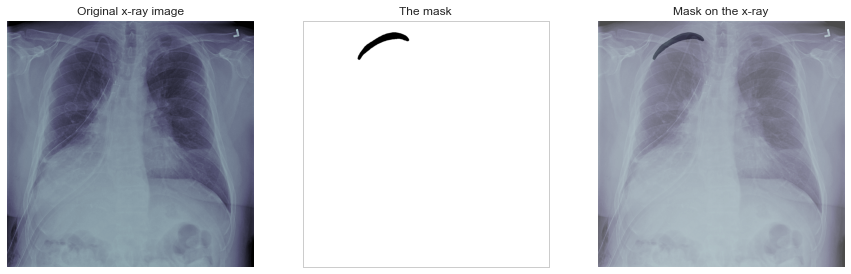

In [290]:
mask =rle2mask(with_pneumothorax.values[100][1], 1024, 1024).T #We have to transpose the masks for them to properly overlap with the xray image
img = dicom.read_file(with_pneumothorax.values[100][-1]).pixel_array #reading the original image 

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray")

plt.axis("off")

plt.grid(False)

mask = rle2mask(with_pneumothorax.values[6][1], 1024, 1024).T #We have to transpose the masks for them to properly overlap with the xray image
img = pydicom.read_file(with_pneumothorax.values[6][-1]).pixel_array #reading the original image 

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray")

plt.axis("off")

plt.grid(False)


mask = rle2mask(with_pneumothorax.values[65][1], 1024, 1024).T #We have to transpose the masks for them to properly overlap with the xray image
img = pydicom.read_file(with_pneumothorax.values[65][-1]).pixel_array #reading the original image 

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray")

plt.axis("off")

plt.grid(False)

In [291]:
with_pneumothorax = patients_train[patients_train["EncodedPixels"] != ' -1'] #patients with Pnuemothorax
PA_pneumothorax=with_pneumothorax[with_pneumothorax['ViewPosition']=='PA']#patients with Pnuemothorax and view position as PA
AP_pneumothorax=with_pneumothorax[with_pneumothorax['ViewPosition']=='AP']#patients with Pnuemothorax and view position as AP

In [292]:
PA_view_non_zero_pixel_count=[]
for p in tqdm(PA_pneumothorax.values):
    try:
        mask = rle2mask(p[1], 1024, 1024)
        pixels = np.count_nonzero(mask)#number of non zero pixel values after getting the mask from the RLE
        PA_view_non_zero_pixel_count.append(pixels)
    except:
      pass

100%|█████████████████████████████████████████████████████████████████████████████| 7290/7290 [00:49<00:00, 145.87it/s]


In [293]:
AP_view_non_zero_pixel_count=[]
for p in tqdm(AP_pneumothorax.values):
    try:
        mask = rle2mask(p[1], 1024, 1024)
        pixels = np.count_nonzero(mask)#number of non zero pixel values after getting the mask from the RLE
        AP_view_non_zero_pixel_count.append(pixels)
    except:
      pass

100%|█████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:30<00:00, 154.97it/s]


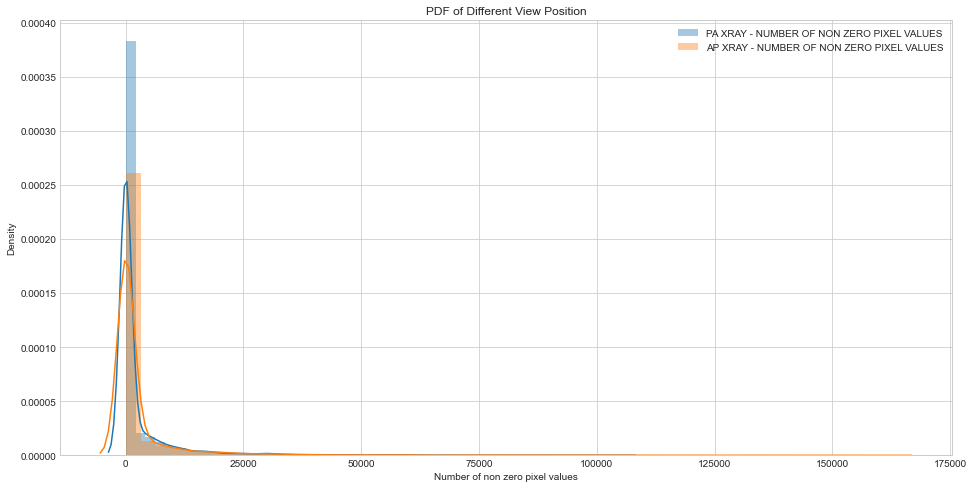

In [309]:
fig=plt.figure(figsize=(16,8))
plt.title("PDF of Different View Position")
sns.distplot(PA_view_non_zero_pixel_count,kde=True,label="PA XRAY - NUMBER OF NON ZERO PIXEL VALUES")
sns.distplot(AP_view_non_zero_pixel_count,kde=True,label="AP XRAY - NUMBER OF NON ZERO PIXEL VALUES")
plt.xlabel("Number of non zero pixel values")
plt.legend()